# 1. Makte templates

In [1]:
import pandas as pd

data = pd.read_parquet("../data/dataset/reddit+shsyt/data.parquet").drop_duplicates(subset="id")
data["yt_id"] = data.id.apply(lambda x: x.split("_", 1)[1])

data["has_WoA"] = data.IOB.apply(lambda x: "B-WoA" in x)
data["has_Artist"] = data.IOB.apply(lambda x: "B-Artist" in x)
data_template = data[data.has_WoA | data.has_Artist]
data_template = data_template[data_template.IOB.apply(lambda x: "O" in x)]


In [2]:
import re

def process_iob_text(data, iob_col='IOB', text_col='TEXT'):
    def process_sequence(iob_tags, text_tokens):
        processed_iob = []
        processed_text = []
        current_class = None

        for iob, token in zip(iob_tags, text_tokens):
            if iob.startswith('B-'):
                current_class = iob[2:]  # Get the class name after 'B-'
                processed_iob.append(current_class)
                processed_text.append(f'[{current_class}]')
            elif iob.startswith('I-') and current_class:
                # Continue the current class, but skip it in output
                continue
            else:
                # It's an 'O' tag or something else
                current_class = None
                processed_iob.append('O')
                processed_text.append(token)
        
        return processed_iob, processed_text

    # Apply the process_sequence function row-wise
    data[['IOB_template', 'TEXT_template']] = data.apply(
        lambda row: process_sequence(row[iob_col], row[text_col]), axis=1, result_type='expand'
    )

    return data

data_template = process_iob_text(data_template)

def replace_years(lst):
    return [re.sub(r'19\d{2}|20\d{2}', '[YEAR]', s) if isinstance(s, str) else s for s in lst]

# Apply the function to the series
data_template.TEXT_template = data_template.TEXT_template.apply(replace_years)

data_template = data_template.drop_duplicates(subset=["TEXT_template"])
data_template["O_tags"] = data_template.TEXT_template.apply(lambda x: [s for s in x if s not in ["[Artist]", "[WoA]", "[YEAR]"]])
data_template["nO_tags"] = data_template["O_tags"].apply(len)


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


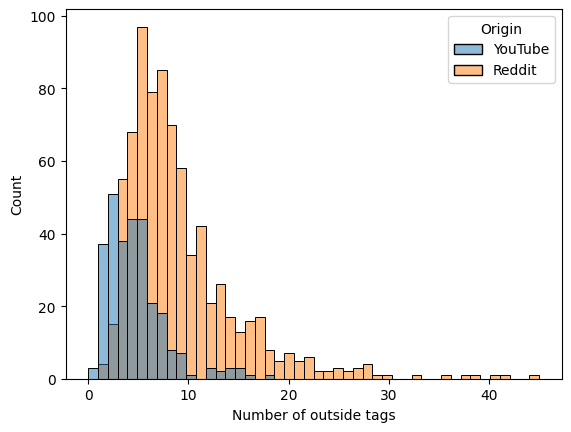

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data_template, x="nO_tags", hue="Origin")
plt.xlabel("Number of outside tags")
plt.savefig("../figures/hist_outside_tokens_templates.pdf")
plt.show()


In [4]:
data_template

,id,set_id,Origin,TEXT,IOB,subset,yt_id,has_WoA,has_Artist,IOB_template,TEXT_template,O_tags,nO_tags
46,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,L1-t3YvFH40,True,True,"[Artist, O, Artist, O, WoA]","[[Artist], &, [Artist], -, [WoA]]","[&, -]",2
79,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,4SE8UvqaSWQ,True,False,"[WoA, O, WoA]","[[WoA], -, [WoA]]",[-],1
170,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",1,hQz-aZH-ozU,True,True,"[Artist, O, WoA]","[[Artist], -, [WoA]]",[-],1
249,58_-cbPbDQhoyg,58.0,YouTube,"[i, cant, help, falling, in, love, -, enrico, ...","[B-WoA, I-WoA, I-WoA, I-WoA, I-WoA, I-WoA, O, ...",1,-cbPbDQhoyg,True,True,"[WoA, O, Artist]","[[WoA], -, [Artist]]",[-],1
367,81_kRssJvqEfzY,81.0,YouTube,"[spanish, harlem, -, alan, haven, and, tony, c...","[O, O, O, B-Artist, I-Artist, O, B-Artist, I-A...",1,kRssJvqEfzY,True,True,"[O, O, O, Artist, O, Artist, O, WoA]","[spanish, harlem, -, [Artist], and, [Artist], ...","[spanish, harlem, -, and, -]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,dataset4_739,12661.0,Reddit,"[looking, for, songs, similar, to, florida, ki...","[O, O, O, O, O, B-WoA, I-WoA, O, B-Artist, I-A...",2,739,True,True,"[O, O, O, O, O, WoA, O, Artist, O]","[looking, for, songs, similar, to, [WoA], (, [...","[looking, for, songs, similar, to, (, )]",7
2672,dataset4_743,12665.0,Reddit,"[gently, wind, |, joshua, speedy]","[B-WoA, I-WoA, O, B-Artist, I-Artist]",1,743,True,True,"[WoA, O, Artist]","[[WoA], |, [Artist]]",[|],1
2676,dataset4_746,12669.0,Reddit,"[songs, like, sub, urbams, cradle, ?]","[O, O, B-Artist, I-Artist, B-WoA, O]",5,746,True,True,"[O, O, Artist, WoA, O]","[songs, like, [Artist], [WoA], ?]","[songs, like, ?]",3
2677,dataset4_747,12670.0,Reddit,"[songs, /, artists, like, quarter, past, midni...","[O, O, O, O, B-WoA, I-WoA, I-WoA, O, B-Artist]",1,747,True,True,"[O, O, O, O, WoA, O, Artist]","[songs, /, artists, like, [WoA], by, [Artist]]","[songs, /, artists, like, by]",5


### Define functions for preprocessing, as in dataset

In [5]:
from typing import List
import sys
sys.path.append("../preprocessing")
from Processor import PerformerStringPreprocessor
from Utils import simplify_string, remove_bracket_with_one_content


def get_title_variations(s: str) -> List[str]:
    s = remove_bracket_with_one_content(s)
    l = s.split("/")
    l = [simplify_string(s) for s in l]
    return l

performer_processor = PerformerStringPreprocessor()

def get_performer_variations(s: str) -> List[str]:
    l = performer_processor.split_performers(s)
    l = [simplify_string(s) for s in l]
    l = performer_processor.article_preprocessing(l)
    return l

get_performer_variations("quentin tarantino feat. steven spielberg")


['quentin tarantino', 'steven spielberg']

### Loading additional info (Exoosure,Memorizationtest,Debut Artists)

#### Debut Artists

In [6]:
entity_dict = {}

data_debut = pd.read_json("../data/intermediate/debut_performers.jsonl", lines=True, orient="records")

list_postcutoff = []
for d in data_debut[["name", "release_title2"]].dropna().to_dict(orient="records"):
    d2 = {}
    d2["Artist"] = get_performer_variations(d["name"].lower())
    d2["WoA"] = get_title_variations(d["release_title2"].lower())
    list_postcutoff.append(d2)

entity_dict["post_cutoff"] = list_postcutoff
list_postcutoff[:5]


[{'Artist': ['kiradeer'], 'WoA': ['kiradeer']},
 {'Artist': ['the mackenzie dynamic', 'mackenzie dynamic'],
  'WoA': ['britparty']},
 {'Artist': ['ben keller'], 'WoA': ['fake you out']},
 {'Artist': ['dj durst'], 'WoA': ['dj durst early demos']},
 {'Artist': ['thistleblade'], 'WoA': ['forgotten north']}]

# Cloze

In [17]:
import random


def fill_template_with_entities(template, entity_dict):
    filled_text = []
    new_iob = []
    used_entities = {key: [] for key in entity_dict.keys()}

    for token in template:
        if isinstance(token, str) and token.startswith('[') and token.endswith(']'):
            placeholder = token.strip('[]')  # Extract entity class name

            if placeholder in entity_dict:
                # Get a random, unused entity from the list for this placeholder
                available_entities = list(set(entity_dict[placeholder]) - set(used_entities[placeholder]))
                if available_entities:
                    chosen_entity = random.choice(available_entities)
                    used_entities[placeholder].append(chosen_entity)
                else:
                    # If we've exhausted all unique entities, re-use from the list
                    chosen_entity = random.choice(entity_dict[placeholder])

                # Tokenize the chosen entity mention
                entity_tokens = chosen_entity.split()

                # Replace the placeholder with the tokenized entity
                filled_text.extend(entity_tokens)

                # Create IOB tags for each token in the entity mention
                new_iob.append(f'B-{placeholder}')
                new_iob.extend([f'I-{placeholder}'] * (len(entity_tokens) - 1))
            else:
                raise ValueError(f"Placeholder '{placeholder}' not found in entity_dict.")
        else:
            # It's a normal token, just append it with an 'O' tag
            filled_text.append(token)
            new_iob.append('O')

    return filled_text, new_iob

# sample example entity
cand_list = entity_dict["post_cutoff"]
ent = cand_list[random.randint(0, len(cand_list))]

# sample example template
template = data_template.TEXT_template.sample(1).item()

fill_template_with_entities(template=template, entity_dict=ent)


(['music', 'like', 'purinsesunoFangChengShi', 'soundtrack', '?'],
 ['O', 'O', 'B-WoA', 'O', 'O'])

In [ ]:
import random

def perturb_characters(text, num_chars_to_perturb):
    """
    Perturb a specific number of characters in the input text.
    
    Args:
        text (str): The original text to perturb.
        num_chars_to_perturb (int): The number of characters to perturb.
        
    Returns:
        str: The perturbed text.
    """
    characters = list(text)
    text_length = len(characters)

    if num_chars_to_perturb > text_length:
        num_chars_to_perturb = text_length

    for _ in range(num_chars_to_perturb):
        perturbation_type = random.choice(["substitution", "deletion", "insertion"])
        index = random.randint(0, len(characters) - 1)
        
        if perturbation_type == "substitution":
            # Replace the character with a random one
            characters[index] = random.choice("abcdefghijklmnopqrstuvwxyz-./_=")
        elif perturbation_type == "deletion" and len(characters) > 1:
            # Remove the character
            characters.pop(index)
        elif perturbation_type == "insertion":
            # Insert a random character
            characters.insert(index, random.choice("abcdefghijklmnopqrstuvwxyz-./="))
    
    return ''.join(characters)


def perturb_tokens(text, perturbation_strength=0.1):
    """
    Perturb tokens in the input text.
    
    Args:
        text (str): The original text to perturb.
        perturbation_strength (float): The proportion of tokens to perturb (0 to 1).
        
    Returns:
        str: The perturbed text.
    """
    tokens = text.split()
    num_perturbations = int(len(tokens) * perturbation_strength)
    
    for _ in range(num_perturbations):
        perturbation_type = random.choice(["substitution", "deletion", "shuffle"])
        index = random.randint(0, len(tokens) - 1)
        
        if perturbation_type == "substitution":
            # Replace the token with a random one (for simplicity, replacing with "RANDOM" token)
            tokens[index] = "RANDOM"
        elif perturbation_type == "deletion" and len(tokens) > 1:
            # Remove the token
            tokens.pop(index)
        elif perturbation_type == "shuffle" and len(tokens) > 1:
            # Shuffle the token with another random token
            swap_index = random.randint(0, len(tokens) - 1)
            tokens[index], tokens[swap_index] = tokens[swap_index], tokens[index]
    
    return ' '.join(tokens)



In [ ]:
perturb_characters("The beatles", num_chars_to_perturb=1)


'Txe beatles'

In [ ]:
# Example usage
text = "This is an example text."
perturbed_text = perturb_tokens(text, perturbation_strength=0.2)
print(perturbed_text)



This is an text.
